# Notebook for the calculation of the equilibrium frequency with the model

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
import time
import pandas as pd
import seaborn as sns
import matplotlib.cm
from scipy.integrate import ode
%matplotlib inline

sns.set()

## Functions

### Model 11

Based on Model 9 from Yurtsev et al. (2013) but includes death in stationary phase and degradation by the sentitive strain

In [5]:
def model11(t, model_state, parms):
    A = model_state[0]
    Nr = np.array(model_state[1])
    Ns = np.array(model_state[2])
    if A <= 0:
        A = 1e-9
    Km = parms.get('Km')
    KmS = parms.get('KmS')
    MIC = parms.get('MIC')
    Vmax = parms.get('Vmax')
    VmaxS = parms.get('VmaxS')
    tlag = parms.get('tlag')
    gR = parms.get('gR')
    gS = parms.get('gS')
    gD = parms.get('gD')
    Nsat = parms.get('Nsat')

    # the derivatives for t < tlag:
    if t < tlag:
        dNrdt = 0
        dNsdt = - gD * Ns * (A>=MIC)
        dAdt = - Vmax * Nr * (A/(A+Km)) - VmaxS * Ns * (A/(A+KmS)) 
    elif Nr + Ns < Nsat:
        dNrdt = gR * Nr
        dNsdt = gS * Ns * (A<MIC) - gD * Ns * (A>=MIC)
        dAdt = - Vmax * Nr * (A/(A+Km)) - VmaxS * Ns * (A/(A+KmS)) 
    else:
        dNrdt = 0
        dNsdt = 0
        dAdt = - Vmax * Nr * (A/(A+Km))

    return np.array([dAdt, dNrdt, dNsdt])

### Function for the simulation of the serial transfer

In [6]:
#Functions for the integration with r.integrate
def serial_transfer(model, iterations, Rf, Ai, Ni, Nsat, parms):
    timeadd = 0
    sol = []
    Nri = Ni*Rf
    Nsi = Ni*(1-Rf)
    params = parms.copy()
    params['Nsat'] = Nsat
    def solout(t, model_state):
        if (model_state[1]+model_state[2])>Nsat:
            return -1
        else:
            sol.append([t, *model_state])
            return 0
    for i in range(0, iterations):
        #set up model
        r = ode(model)
        r.set_integrator('dopri5', nsteps=10000) # Integrator that supports solout
        r.set_initial_value(np.array([Ai, Nri, Nsi]))
        r.set_f_params(params)
        r.set_solout(solout)
        r.integrate(100)
        #adjust the time
        asol = np.array(sol)
        asol[:,0] = asol[:,0] + timeadd
        if i==0:
            totalsol = asol
        else:
            totalsol = np.concatenate((totalsol,asol))
        #reset
        Nri, Nsi = tuple(Ni*np.array(sol[-1][2:])/(sol[-1][2]+sol[-1][3]))
        timeadd += sol[-1][0]
        sol = []
    return totalsol

### Functions for the calculation of the equilibrium frequency

In [7]:
#This functions gives the ratio of the triple from a result of the simulation
def calc_ratio(model_state):
    return model_state[2]/(model_state[2]+model_state[3])

The below function calculates the equilibrium ratio on the bases of the simulation of single tranfers from different starting ratios of the resistant strain, with a given sensitivity. If the sensitivity is not reachted within max_iterations the best guess will be returned with a warning that the sensitity was not reached.

First, the function checks if the result is close to 0 or 1 (between that and the given sensitivity), in which case it returns 0 or 1.

Otherwise, the averate is checked, and depinding on if the ratio increases or decreases, the lower or higher interval is discarded. This is continued untill the remaining interval is smaller than the sensitivity and the the middle of the remaining interval is returned.

In [8]:
def equilibrium_ratio(init, parms, sensitivity=0.001, max_iterations=50):
    ratio_low = 0 + sensitivity
    ratio_high = 1 - sensitivity
    iterations = 0
    if calc_ratio(serial_transfer(model11, 1, ratio_low, parms=parms, **init)[-1]) < ratio_low:
        return 0
    if calc_ratio(serial_transfer(model11, 1, ratio_high, parms=parms, **init)[-1]) > ratio_high:
        return 1
    while abs(ratio_high - ratio_low) > sensitivity:
        if iterations == max_iterations:
            print("Precision not reached: Difference is", abs(ratio_high - ratio_low))
            break
        ratio_check = ratio_low + 0.5*(ratio_high - ratio_low)
        ratio_check_end = calc_ratio(serial_transfer(model11, 1, ratio_check, parms=parms, **init)[-1])
        if ratio_check_end > ratio_check:
            ratio_low = ratio_check
        elif ratio_check_end < ratio_check:
            ratio_high = ratio_check
        iterations += 1
    return ratio_low + (ratio_high-ratio_low)/2

## Parameter sets used in this file

In [9]:
# These numbers are from the manuscript
p = {'Km': 69, 'MIC': 1, 'Vmax': 3.20e-4, 'tlag':8.5, 'gR': 0.185, 'gS': 0.190, 'gD': 1.54, 'VmaxS': 6.69e-4, 'KmS': 319}

In [10]:
# Adjusted parameters (gR and VmaxS) to show the difference equation plots change with different parameters
p_adj = {'Km': 69, 'MIC': 1, 'Vmax': 3.20e-4, 'tlag':8.5, 'gR': 0.175, 'gS': 0.190, 'gD': 1.54, 'VmaxS': 3.506e-6, 'KmS': 319}

## Simulation of the serial transfer (not directly used for figures in paper)

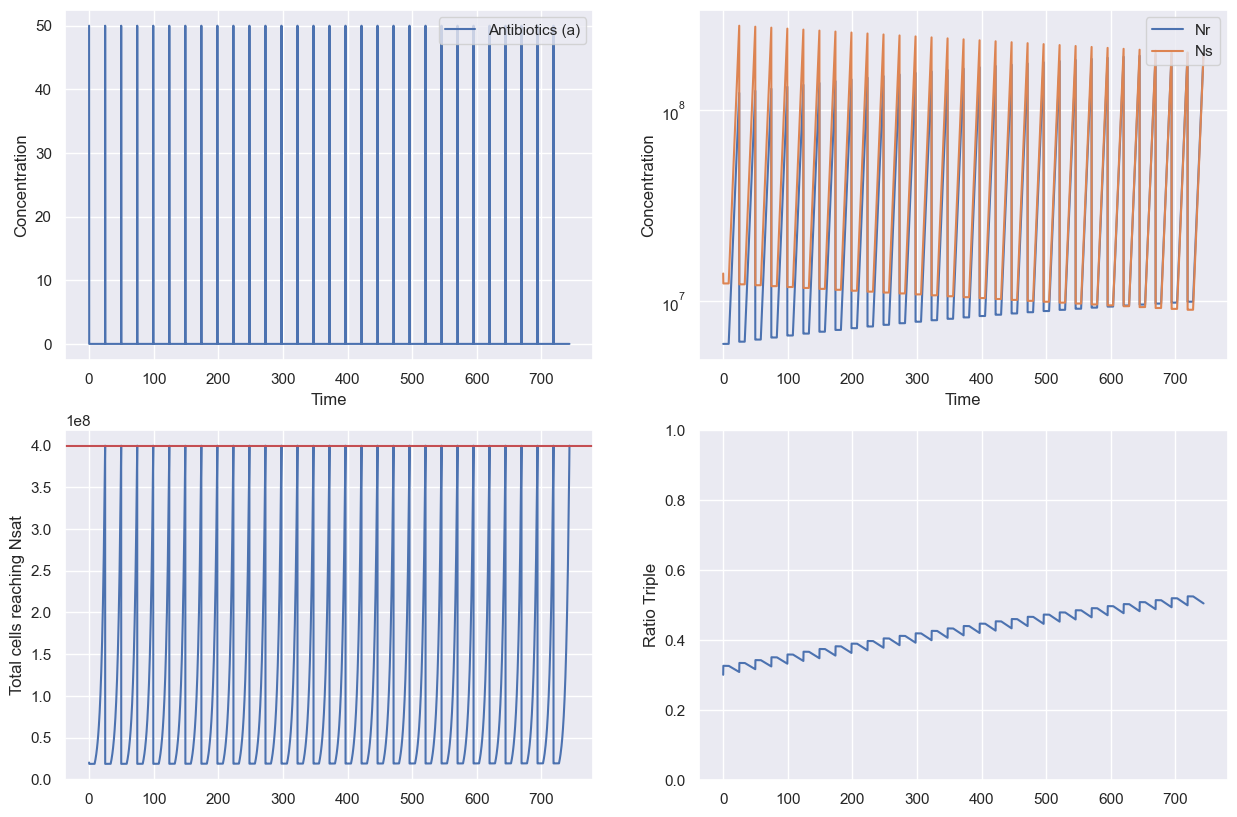

In [11]:
# These parameters can be adjusted to simulate different senearios

glycerol_concentration = 0.2
antibiotic_concentration = 50
dilution = 20
nr_of_transfers = 30
initial_frequency_triple = .3

#This runs the simulations and makes the plots using the parameters from the paper

inits = {"Ai": antibiotic_concentration, "Ni": 2e9*glycerol_concentration/dilution, "Nsat":2e9*glycerol_concentration}

result = serial_transfer(model11, nr_of_transfers, initial_frequency_triple, parms=p, **inits)

fig, axes = plt.subplots(2,2, figsize=(15,10))

axes[0,0].plot(result[:,0], result[:,1])
axes[0,1].plot(result[:,0], result[:,2])
axes[0,1].plot(result[:,0], result[:,3])
axes[1,0].plot(result[:,0], result[:,2]+result[:,3])
axes[1,1].plot(result[:,0], result[:,2]/(result[:,2]+result[:,3]))
axes[1,0].axhline(y=inits['Nsat'], color='r', linestyle='-')

axes[0,0].set_xlabel('Time')
axes[0,1].set_xlabel('Time')
axes[0,0].set_ylabel('Concentration')
axes[0,1].set_ylabel('Concentration')
axes[1,0].set_ylabel('Total cells reaching Nsat')
axes[1,1].set_ylabel('Ratio Triple')
axes[0,1].set_yscale('log')
axes[1,1].set_ylim([0,1])
axes[0,0].legend(tuple(['Antibiotics (a)']), loc="upper right")
axes[0,1].legend(tuple(['Nr', 'Ns']), loc="upper right")

## Heatmap of dependencies of the equilibrium frequency on substrate and antibiotics

We create a mesh of different antibiotics and substrate concentrations on a log scale. Then we calculate the equilibrium concentration for all of them and plot them using a contour plot.

Either comment out the "EQ = " between the tic and toc and the "np.save", when you have the data pre-computed, or otherwise the "np.load".

In [12]:
a_list = np.geomspace(0.5,100,100)
s_list = np.geomspace(0.002,2,100)

A, S = np.meshgrid(a_list, s_list)

In [13]:
tic = time.perf_counter()
#EQ = [[equilibrium_ratio({"Ai": a, "Ni": 2e9*s/20, "Nsat":2e9*s}, p, 0.01, 25) for a in a_list] for s in s_list]
toc = time.perf_counter()
print(f"The simulations take {toc - tic:0.4f} seconds")

The simulations take 0.0000 seconds


In [14]:
#export data
#np.save('data/eqratios.npy', EQ)

In [15]:
EQ = np.load('data/eqratios.npy')

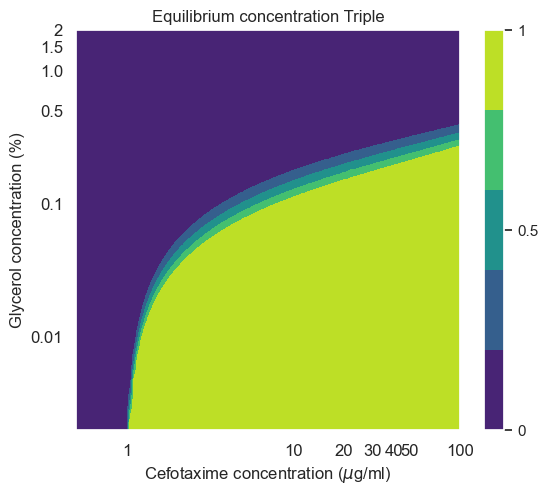

In [29]:
fig = plt.figure(figsize=(6,5))

left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 

levels = np.linspace(0,1,101, endpoint=True)
cp = plt.contourf(A, S, EQ, levels=4,cmap=cm.viridis)
cbar = plt.colorbar(cp)
cbar.set_ticks([0,.5,1])
cbar.set_ticklabels([0,.5,1])

ax.set_title('Equilibrium concentration Triple')
ax.set_xlabel(r'Cefotaxime concentration ($\mu$g/ml)')
ax.set_ylabel('Glycerol concentration (%)')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(0.5, 100)
ax.set_ylim(0.002, 2)
ax.set_xticks([1,10,20,30,40,50,100]) 
ax.set_xticklabels([1,10,20,30,40,50,100], fontsize=12)
ax.set_yticks([0.01,0.1,0.5,1.0,1.5,2]) 
ax.set_yticklabels([0.01,0.1,0.5,1.0,1.5,2], fontsize=12)
plt.savefig("eqq_model.pdf", format="pdf", bbox_inches="tight")
plt.show()


## Difference equation

We simulate one timestep for 21 different initial ratios of the resistant strain (between 0 and 1) and plot those as a difference equation. Here the crossing of the diagonal shows the frequency in steady state.

### Experimental setting

In [15]:
inits_experiment = [{"Ai": a, "Ni": 2e9*g/20, "Nsat": 2e9*g} for a in [12.5, 25, 50] for g in [0.2, 0.43, 0.93, 2]]

sim_diff_eq = np.array([[i["Ai"],i["Ni"],r, calc_ratio(serial_transfer(model11, 1, r, parms=p, **i)[-1])] for r in np.linspace(0,1,21,endpoint=True) for i in inits_experiment])

In [16]:
sim_diff_eq_dataframe = pd.DataFrame(data=sim_diff_eq, columns=['CTX','Ni','Ratio','Final_Ratio'])

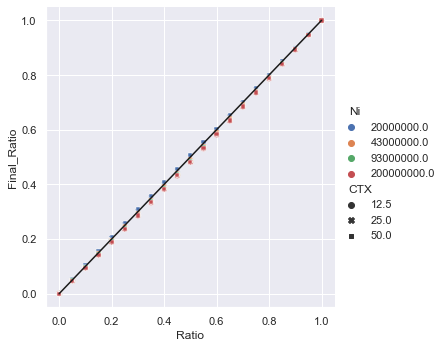

In [17]:
sns.relplot(data=sim_diff_eq_dataframe, x="Ratio", y="Final_Ratio", hue='Ni', style='CTX', palette="deep")
X_plot = np.linspace(0, 1, 100)

plt.plot(X_plot,X_plot, c='k')
plt.show()

### Wider range of antibiotic and substrate concentrations

In [18]:
inits_wide_range = [{"Ai": a, "Ni": 2e9*g/20, "Nsat": 2e9*g} for a in [12.5, 25, 50, 100] for g in [0.02, 0.043, 0.093, 0.2, 0.43, 0.93, 2]]

sim_diff_eq_wide_range = np.array([[i["Ai"],i["Ni"],r, calc_ratio(serial_transfer(model11, 1, r, parms=p, **i)[-1])] for r in np.linspace(0,1,21,endpoint=True) for i in inits_wide_range])

In [19]:
sim_diff_eq_wide_range_dataframe = pd.DataFrame(data=sim_diff_eq_wide_range, columns=['CTX','Ni','Ratio','Final_Ratio'])

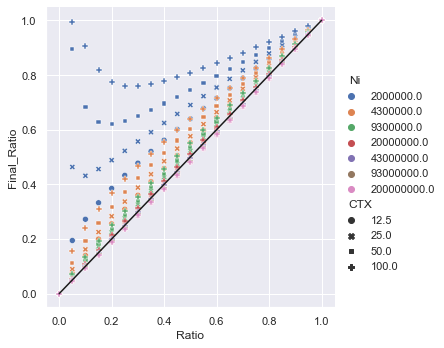

In [20]:
sns.relplot(data=sim_diff_eq_wide_range_dataframe, x="Ratio", y="Final_Ratio", hue='Ni', style='CTX', palette="deep")
X_plot = np.linspace(0, 1, 100)

plt.plot(X_plot,X_plot, c='k')
plt.show()

### Difference equation for different parameters

We show that if the difference in growth rates is larger and the degradation of antibiotics by the susceptible strain is slower, we get a different type of figure that resambles more the case of HGT shown by Yurtsev et al. (2013)

In [21]:
inits_diff_p = [{"Ai": a, "Ni": 2e9*g/20, "Nsat": 2e9*g} for a in [12.5, 100] for g in [0.02, 0.2, 2]]

sim_diff_eq_p_adj = np.array([[i["Ai"],i["Ni"],r, calc_ratio(serial_transfer(model11, 1, r, parms=p_adj, **i)[-1])] for r in np.linspace(0,1,21,endpoint=True) for i in inits_diff_p])

In [22]:
sim_diff_eq_p_adj_df = pd.DataFrame(data=sim_diff_eq_p_adj, columns=['CTX','Ni','Ratio','Final_Ratio'])

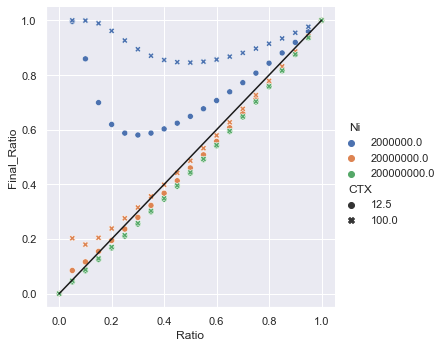

In [23]:
sns.relplot(data=sim_diff_eq_p_adj_df, x="Ratio", y="Final_Ratio", hue='Ni', style='CTX', palette="deep")
X_plot = np.linspace(0, 1, 100)

plt.plot(X_plot,X_plot, c='k')
plt.show()